# MDN + Tensorboard Hands On Tutorial

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Tensorboard log directory:
LOGDIR = './tb/'

In [3]:
def f(x):
    return x**2-6*x+9 

In [4]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

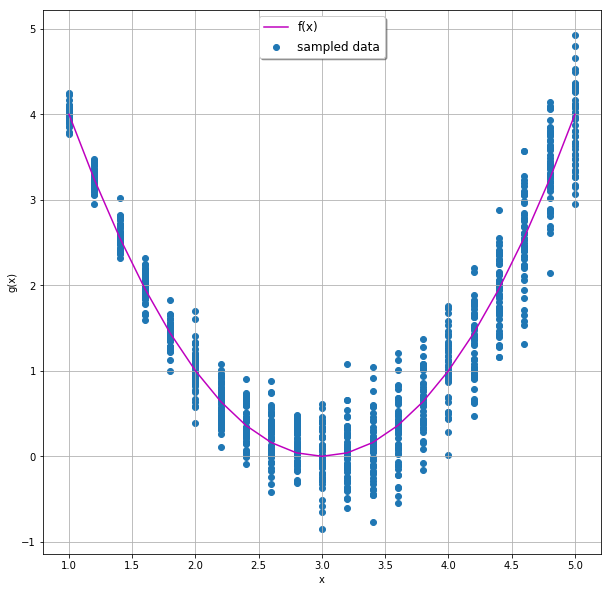

In [5]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Regular neural network

Epoch 0 | cost = 5.1905
Epoch 50 | cost = 1.5977
Epoch 100 | cost = 0.2894
Epoch 150 | cost = 0.1460
Epoch 200 | cost = 0.1201
Epoch 250 | cost = 0.1101
Epoch 300 | cost = 0.1093
Epoch 350 | cost = 0.1111
Epoch 400 | cost = 0.1048
Epoch 450 | cost = 0.1044
Final cost: 0.1050


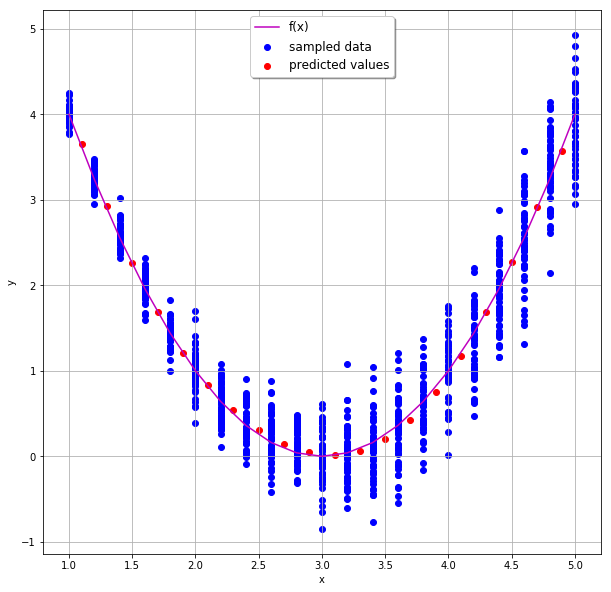

In [6]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for i in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh, name="dense"+str(i))
    tf.summary.histogram("dense"+str(i),layer)
        
output = tf.layers.dense(inputs=layer, units=1,name="output")
tf.summary.histogram("output",output)
    
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y,predictions=output))
tf.summary.scalar("cost", cost)
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

summ = tf.summary.merge_all()

x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Tensorboard writer setup
    writer = tf.summary.FileWriter(LOGDIR + 'regular') 
    writer.add_graph(sess.graph) 
    
    for epoch in range(epochs):
        avg_cost = 0.0
        x_batches, y_batches = shuffle(x_batches, y_batches)
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        s = sess.run(summ, feed_dict={x:x_batch, y:y_batch})
        writer.add_summary(s,epoch)
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    y_pred = sess.run(output,feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Mixture density network (MDN)

In [7]:
def mdn_cost(mu, sigma, y):
    with tf.name_scope("cost"):
        dist = tf.distributions.Normal(loc=mu, scale=sigma)
        return tf.reduce_mean(-dist.log_prob(y))

Epoch 0 | cost = 2.7548
Epoch 50 | cost = 1.6932
Epoch 100 | cost = 0.6938
Epoch 150 | cost = 0.3021
Epoch 200 | cost = 0.2246
Epoch 250 | cost = 0.1870
Epoch 300 | cost = 0.1607
Epoch 350 | cost = 0.1591
Epoch 400 | cost = 0.1597
Epoch 450 | cost = 0.1332
Final cost: 0.1308


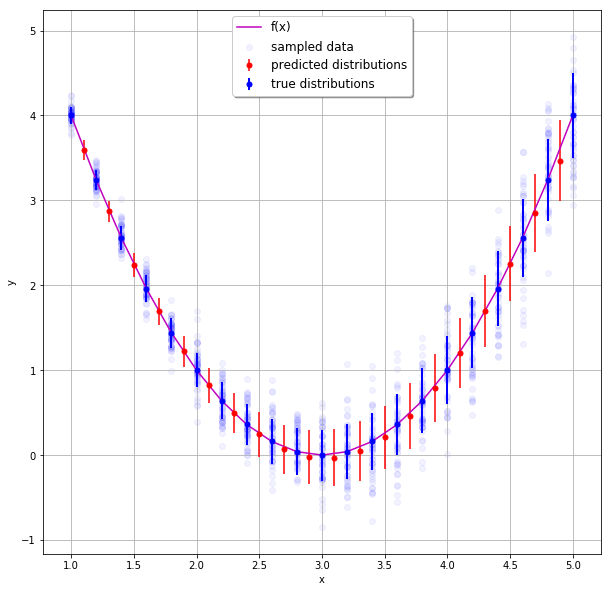

In [8]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
display_step = 50
batch_num = int(len(x_arr) / batch_size)

tf.reset_default_graph()
x = tf.placeholder(name='x',shape=(None,1),dtype=tf.float32)
y = tf.placeholder(name='y',shape=(None,1),dtype=tf.float32)

layer = x
for i in range(3):
    layer = tf.layers.dense(inputs=layer, units=12, activation=tf.nn.tanh, name="dense"+str(i))
    tf.summary.histogram("dense"+str(i),layer)

mu = tf.layers.dense(inputs=layer, units=1, name="mu")
tf.summary.histogram("mu",layer)
sigma = tf.layers.dense(inputs=layer, units=1, activation=lambda x: tf.nn.elu(x) + 1, name="sigma")
tf.summary.histogram("sigma",layer)

cost = mdn_cost(mu, sigma, y)
tf.summary.scalar("cost", cost)

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
summ = tf.summary.merge_all()

x_batches = np.array_split(x_arr, batch_num)
y_batches = np.array_split(y_arr, batch_num)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Tensorboard writer setup
    writer = tf.summary.FileWriter(LOGDIR + 'mdn') 
    writer.add_graph(sess.graph) 
    
    for epoch in range(epochs):
        avg_cost = 0.0
        x_batches, y_batches = shuffle(x_batches, y_batches)
        for i in range(batch_num):
            x_batch = np.expand_dims(x_batches[i],axis=1)
            y_batch = np.expand_dims(y_batches[i],axis=1)
            _, c = sess.run([optimizer,cost], feed_dict={x:x_batch, y:y_batch})
            avg_cost += c/batch_num
        s = sess.run(summ, feed_dict={x:x_batch, y:y_batch})
        writer.add_summary(s,epoch)
        if epoch % display_step == 0:
            print('Epoch {0} | cost = {1:.4f}'.format(epoch,avg_cost))
    mu_pred, sigma_pred = sess.run([mu,sigma],feed_dict={x:np.expand_dims(x_test,axis=1)})
    print('Final cost: {0:.4f}'.format(avg_cost))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,map(f,x_vals),yerr=map(lambda x: sigma_0*x,x_vals),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,map(f,x_vals),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()